# GAN-80-Lines-of-Julia  
This notebook is a demonstration of how to train simple GAN for MNIST by using Julia. It will highlight how one can write a model and related mathematical equations in Julia just like writing a paper. Let's start!

## Setup
We will use Knet.jl deep learning package to compute gradients for the networks and to use GPU arrays if a gpu device available.

In [1]:
using Knet,Images, Colors,ImageView
include(Pkg.dir("Knet","data","mnist.jl")) #importing MNIST data loader functions
global atype = gpu()>=0 ? KnetArray{Float32} : Array{Float32}

Array{Float32,N} where N

## MLP Model  
We will define a generic multi-layer perceptron to use for discriminator and generator. $\mathbf{w}$ is an array keeps model paramaters and $\mathbf{x}$ will be input. Keyword arguments $\mathbf{p}$ is dropout probability, `activation`  is the activation function used in the hidden layers, `outputactivation` is the activation function used in output layer. We also defined `leakyrelu` activation function since it is not defined in default.

In [2]:
function mlp(w,x;p=0.0,activation=leakyrelu,outputactivation=sigm)
    for i=1:2:length(w)
        x = w[i]*dropout(mat(x),p) .+ w[i+1]   # mat() used for flatten images to vector.
        i<length(w)-1 && (x = activation.(x)) 
    end
    return outputactivation.(x) #output layer
end
leakyrelu(x;α=Float32(0.2)) = max(0,x) + α*min(0,x)

leakyrelu (generic function with 1 method)

## Discriminator and Generator Networks

Discriminator and Generator networks are simple MLPs named as `D` and `G` in the code. Loss functions `Jd` and `𝑱g` are defined according to equation X in GAN paper. Sample noise function `𝒩` is a normal distribution.

In [3]:
global const 𝜀=Float32(1e-8)
D(w,x;p=0.0) = mlp(w,x;p=p)
G(w,z;p=0.0) = mlp(w,z;p=p) 
𝑱d(𝗪d,x,Gz) = -mean(log.(D(𝗪d,x)+𝜀)+log.(1-D(𝗪d,Gz)+𝜀))/2   
𝑱g(𝗪g, 𝗪d, z) = -mean(log.(D(𝗪d,G(𝗪g,z))+𝜀))           
𝒩(input, batch) = atype(randn(Float32, input, batch))  #SampleNoise

𝒩 (generic function with 1 method)

## Gradient Functions

For backpropogation we need the derivatives of loss functions according to model parameters. This is where Knet comes to play. The `Knet.grad` function calculates gradient according to first parameter of any function. So,

In [4]:
∇d  = grad(𝑱d) # Discriminator gradient
∇g  = grad(𝑱g) # Generator gradient

(::gradfun) (generic function with 1 method)

## Parameter Initialization
It is a generic weight initialization function for MLPs. For each layer, it creates a weight matrix and bias vector, then add them to $W$. 

In [5]:
function initweights(hidden,input, output)
    𝗪 = Any[];
    x = input
    for h in [hidden... output]
        push!(𝗪, atype(xavier(h,x)), atype(zeros(h, 1))) #FC Layers weights and bias
        x = h
    end
    return 𝗪  #return model params
end

initweights (generic function with 1 method)

## Generate and Display

This function generates random `number` images and displays here.

In [21]:
function generate_and_show(𝗪,number,𝞗;fldr="generations/")
    Gz = G(𝗪[1],𝒩(𝞗[:ginp],number)) .> 0.5
    Gz = permutedims(reshape(Gz,(28,28,number)),(2,1,3))
    [display(Gray.(Gz[:,:,i])) for i=1:number]
end

generate_and_show (generic function with 1 method)

## Train & Test Function

This `runmodel` function is implementing training procedure described in GAN paper. It first update discriminator with specified optimizer, then update generator network. Same function can be used in test mode by passing `train` argument as false. In the test mode it calculates losses instead of gradients.

In [7]:
function runmodel(𝗪, data, 𝞗;dtst=nothing,optim=nothing,train=false,saveinterval=10)
    gloss=dloss=total=0.0;
    B = 𝞗[:batchsize]
    for i=1:(train ? 𝞗[:epochs]:1)
        for (x,_) in data
            Gz = G(𝗪[1],𝒩(𝞗[:ginp],B)) #Generate Fake Images
            train ? update!(𝗪[2], ∇d(𝗪[2],x,Gz), optim[2]) : (dloss += 2B*𝑱d(𝗪[2],x,Gz))
            
            z=𝒩(𝞗[:ginp],2B) #Sample z from Noise
            train ? update!(𝗪[1], ∇g(𝗪[1], 𝗪[2], z), optim[1]) : (gloss += 2B*𝑱g(𝗪[1],𝗪[2],z))    
            
            total+=2B
        end
        train ? runmodel(𝗪,dtst,𝞗;train=false) : println((gloss/total,dloss/total)) #Print average losses in each epoch
        i % saveinterval == 0 && generate_and_show(𝗪,10,𝞗)  # save 10 images
    end
end

runmodel (generic function with 1 method)

## Run

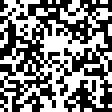

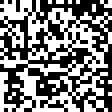

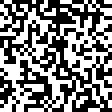

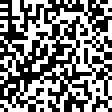

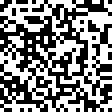

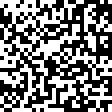

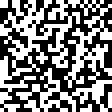

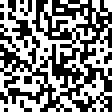

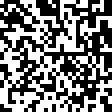

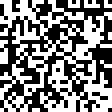

10-element Array{Void,1}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [22]:
𝞗 = Dict(:batchsize=>32,:epochs=>75,:ginp=>256,:genh=>[512],:disch=>[512],:optim=>Adam,:lr=>0.002);
xtrn,ytrn,xtst,ytst = mnist()
global dtrn = minibatch(xtrn, ytrn, 𝞗[:batchsize]; xtype=atype)
global dtst = minibatch(xtst, ytst, 𝞗[:batchsize]; xtype=atype)
𝗪  = (𝗪g,𝗪d)   = initweights(𝞗[:genh], 𝞗[:ginp], 784), initweights(𝞗[:disch], 784, 1)
𝚶  = (𝚶pg,𝚶pd) =  optimizers(𝗪g,𝞗[:optim];lr=𝞗[:lr]), optimizers(𝗪d,𝞗[:optim];lr=𝞗[:lr])
runmodel(𝗪, dtst, 𝞗;optim=𝚶, train=false) # initial losses
runmodel(𝗪, dtrn, 𝞗;optim=𝚶,train=true, dtst=dtst) # training  